## **i. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **ii. Import the libraries**
---

In [2]:
import cv2
import sys
import os
import scipy
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print("Versions of key libraries")
print("---")
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas:    ", pd.__version__)
print("scipy:     ", scipy.__version__)


Versions of key libraries
---
numpy:      1.18.5
matplotlib: 3.2.2
pandas:     1.1.2
scipy:      1.4.1


## **iii. Append /iss/issm/data/ in your python path**
---

In [3]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Intelligent_Sense_Making/')
print("All the system paths:")
sys.path

All the system paths:


['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Colab Notebooks/Intelligent_Sense_Making/']

## **iv. Change working directory to /iss/issm/data/**
---

In [4]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Intelligent_Sense_Making/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/Colab Notebooks/Intelligent_Sense_Making'

## **v. Setup matplotlib**
---

In [5]:
plt.style.use('ggplot')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **1. Create 3 plot functions**
---
* `pltDistances`: For distance matrix and accumulated cost matrix
* `pltCostAndPath`: Plot accumulated cost matrix together with the optimal path
* `pltWarp`: Plot point-to-point connection between two signals

In [6]:
def pltDistances(dists,xlab="X",ylab="Y",clrmap="viridis"):
    imgplt  = plt.figure()
    plt.imshow(dists,
               interpolation='nearest',
               cmap=clrmap)
    
    plt.gca().invert_yaxis()    # This is added so that the y axis start from bottom, instead of top
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.colorbar()
    
    return imgplt

# ..........

def pltCostAndPath(acuCost,path,xlab="X",ylab="Y",clrmap="viridis"):
    px      = [pt[0] for pt in path]
    py      = [pt[1] for pt in path]
    
    imgplt  = pltDistances(acuCost,
                           xlab=xlab,
                           ylab=ylab,
                           clrmap=clrmap)  
    plt.plot(px,py)
    
    return imgplt

# ..........

def pltWarp(s1,s2,path,xlab="idx",ylab="Value"):
    imgplt      = plt.figure()
    
    for [idx1,idx2] in path:
        plt.plot([idx1,idx2],[s1[idx1],s2[idx2]],
                 color="C4",
                 linewidth=2)
    plt.plot(s1,
             'o-',
             color="C0",
             markersize=3)
    plt.plot(s2,
             's-',
             color="C1",
             markersize=2)
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    return imgplt

print(pltDistances)
print(pltCostAndPath)
print(pltWarp)

<function pltDistances at 0x7f9495524c80>
<function pltCostAndPath at 0x7f949ee13840>
<function pltWarp at 0x7f949ee137b8>


## **2. Create functions to compute distance matrix and accumulated cost matrix**
---


In [7]:
def computeDists(x,y):
    dists       = np.zeros((len(y),len(x)))
    
    for i in range(len(y)):
        for j in range(len(x)):
            dists[i,j]  = (y[i]-x[j])**2
            
    return dists


# ..............


def computeAcuCost(dists):
    acuCost     = np.zeros(dists.shape)
    acuCost[0,0]= dists[0,0]
                                                # Calculate the accumulated costs along the first row
    for j in range(1,dists.shape[1]):           # the running number starts from 1, not 0
        acuCost[0,j]    = dists[0,j]+acuCost[0,j-1]
        
                                                # Calculate the accumulated costs along the first column
    for i in range(1,dists.shape[0]):           # the running number starts from 1, not 0
        acuCost[i,0]    = dists[i,0]+acuCost[i-1,0]    
    
                                                # Calculate the accumulated costs from second column, row onwards    
    for i in range(1,dists.shape[0]):
        for j in range(1,dists.shape[1]):
            acuCost[i,j]    = min(acuCost[i-1,j-1],
                                  acuCost[i-1,j],
                                  acuCost[i,j-1])+dists[i,j]
            
    return acuCost

print(computeDists)
print(computeAcuCost)

<function computeDists at 0x7f9494df8598>
<function computeAcuCost at 0x7f9494df86a8>


## **3. Create the function to perform dynamic time warping**
---

In [8]:
def doDTW(x,y,dists,acuCost):
    
    i       = len(y)-1
    j       = len(x)-1
                                                # Do backtracking to find out the warping path
    path    = [[j,i]]                           # The last point at the top-right is the starting point
                                                # Do note that, it is '[[j,i]]', not [[i,j]]
                                                # This is because we want the correct mapping in the pair ('path' is a list of pairs): 
                                                # the first element corresponds to 'x', the second element to 'y'
    
    while (i > 0) and (j > 0):
        if i==0:
            j   = j-1                           # When the search hits the bottom border, the next point to back track
                                                # is just the point to the left
            
        elif j==0:
            i   = i-1                           # When the search hits the left border, the next point to back track
                                                # is just the point to the bottom
        
        else:
                                                # For each point [i,j], there are only three points to back track:
                                                # the point to the left
                                                # the point to the bottom
                                                # the point to the left-bottom 
                                                
                                                # Among the three, find out which has the lowest accumulated cost
                                                # then that is the point
            
            if acuCost[i-1,j] == min(acuCost[i-1,j-1],
                                     acuCost[i-1,j],
                                     acuCost[i,j-1]):
                i   = i-1
                
            elif acuCost[i,j-1] == min(acuCost[i-1,j-1],
                                       acuCost[i-1,j],
                                       acuCost[i,j-1]):
                j   = j-1
                
            else:
                i   = i-1
                j   = j-1
                
        path.append([j,i])       
    path.append([0,0])
    
    cost        = 0
    for [j,i] in path:
        cost    = cost+dists[i,j]
        
    return path,cost

print(doDTW)

<function doDTW at 0x7f949ee13d90>


## **4. Extract ECG segments**
---
* Step 1: Load ECG signals
* Step 2: Perform peak detection
* Step 3: Extract segments based on the detected peaks

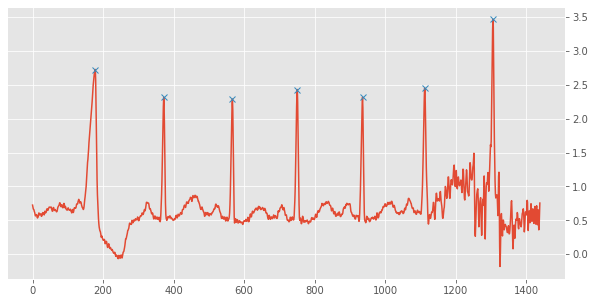

In [9]:
# Type your code below

from scipy.signal import find_peaks as findPeaks
                                                                                # Step 1
l2D     = pd.read_csv('ecg2D.csv',
                      header=None)

# Chose 2nd Column within the Dataset as the interested signal
ECGs    = l2D[1].values

                                                                                # Step 2
(Pks,_)      = findPeaks(ECGs,prominence=0.5,distance=100)

plt.figure(figsize=(10,5))
plt.plot(ECGs)
plt.plot(Pks,ECGs[Pks],'x')

                                                                                # Step 3
def extractECG(ecg,pks,offset=15):
    segs    = []
    
    if pks[0]-offset < 0:
        start   = 1
    else:
        start   = 0
    
    for i in range(start,len(pks)-1):
        seg = ecg[(pks[i]-offset):(pks[i+1]-offset)]
        segs.append(seg)
        
    return segs

EcgSegs     = extractECG(ECGs,Pks)

Examine the number of segments and the length of each segment

In [10]:
print("In total there are", len(EcgSegs), "segments.")

if len(EcgSegs) > 0:
  for i in range(len(EcgSegs)):
    print("Length of segment",i,":", len(EcgSegs[i]))

In total there are 6 segments.
Length of segment 0 : 195
Length of segment 1 : 195
Length of segment 2 : 184
Length of segment 3 : 185
Length of segment 4 : 176
Length of segment 5 : 194


## **5.Perform dynamic time warping on ECG segments**
---

In [11]:
# Type your code below

def dtwOnECGs(segments,idx1,idx2):
  dist          = computeDists(segments[idx1],segments[idx2])
  acuCost       = computeAcuCost(dist)
  (path,cost)   = doDTW(segments[idx1],
                        segments[idx2],
                        dist,
                        acuCost)
  
  return (dist,acuCost,path,cost)

print(dtwOnECGs)

<function dtwOnECGs at 0x7f948acf5840>


   The warping cost between ECG segment 1 and 2 is 16.51980000000001
   -------------------------------


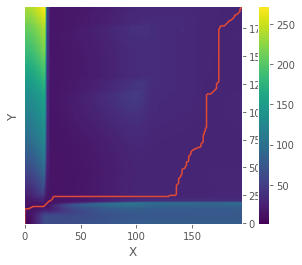

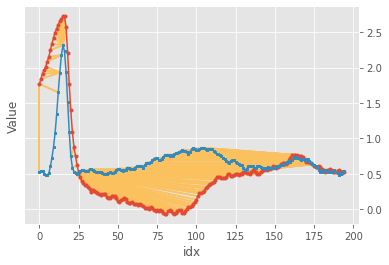

In [12]:
sg1             = 0
sg2             = 1
(d,a,p,c)       = dtwOnECGs(EcgSegs,sg1,sg2)
pltCostAndPath(a,p)
pltWarp(EcgSegs[sg1],
        EcgSegs[sg2],
        p)
print('   The warping cost between ECG segment 1 and 2 is',c)
print('   -------------------------------')

   The warping cost between ECG segment 2 and 3 is 0.7598750000000004
   -------------------------------


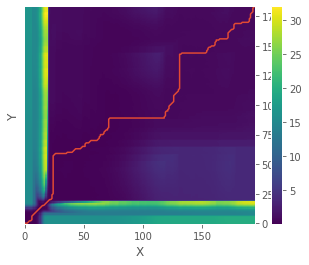

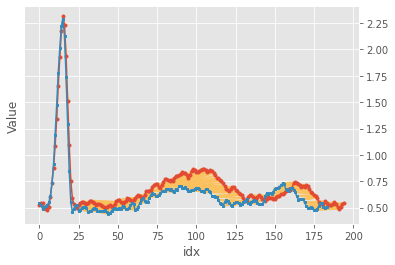

In [13]:
sg2             = 1
sg3             = 2
(d,a,p,c)       = dtwOnECGs(EcgSegs,sg2,sg3)
pltCostAndPath(a,p)
pltWarp(EcgSegs[sg2],
        EcgSegs[sg3],
        p)
print('   The warping cost between ECG segment 2 and 3 is',c)
print('   -------------------------------')

   The warping cost between ECG segment 2 and 6 is 8.4063
   -------------------------------


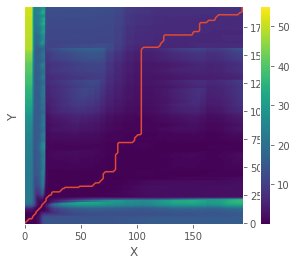

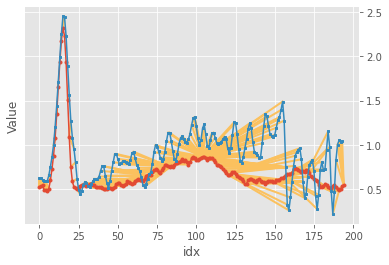

In [14]:
sg2             = 1
sg6             = 5
(d,a,p,c)       = dtwOnECGs(EcgSegs,sg2,sg6)
pltCostAndPath(a,p)
pltWarp(EcgSegs[sg2],
        EcgSegs[sg6],
        p)
print('   The warping cost between ECG segment 2 and 6 is',c)
print('   -------------------------------')